### Expectation-Maximization (EM) algorithm using MAP estimation 
From Wittmann, M. K., Fouragnan, E., Folloni, D., Klein-Flügge, M. C., Chau, B. K., Khamassi, M., & Rushworth, M. F. (2020). Global reward state affects learning and activity in raphe nucleus and anterior insula in monkeys. Nature Communications, 11(1), 3771. https://www.nature.com/articles/s41467-020-17343-w#Sec10 

Key points:
Negative Log-Likelihood (negll):
The negative log-likelihood is a measure of how well the model fits the observed data. It is obtained by taking the negative natural logarithm of the likelihood function. The goal of MLE is to find the parameter values that minimize the negative log-likelihood, effectively maximizing the likelihood of the observed data given the model.

Prior Probability (prior_logpdf):
The prior probability represents your knowledge or belief about the parameters before observing the data. It is typically based on some prior information or assumptions. In this case, you are using a normal distribution to represent your prior beliefs about the parameters, with mean prior['mu'] and standard deviation np.sqrt(prior['sigma']).

MAP Estimation:
In MAP estimation, you are incorporating the prior probability into the estimation process. Instead of only maximizing the likelihood (as in MLE), you are maximizing the posterior probability, which combines the likelihood and the prior. Mathematically, MAP estimation can be expressed as: `argmax_{theta} (likelihood(theta | data) * prior(theta))`, where theta represents the model parameters

We are effectively combining the likelihood and the prior in a way that biases the parameter estimation towards the prior beliefs. Since we are maximizing this combined term, we are seeking parameter values that not only fit the data well (as indicated by the negll) but also align with the prior probability distribution.

In [3]:
%load_ext autoreload
%autoreload 2

In [29]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import seaborn as sns, pickle, os, itertools, datetime
from copy import deepcopy
from scipy.optimize import minimize
from scipy.stats import norm, multivariate_normal, beta, gamma
import sys
sys.path.append('../')
from pyEM.fitting import expectation_step, EMfit
from pyEM.math import *
from pyEM import plotting
from joblib import Parallel, delayed
from tqdm import tqdm

In [5]:
nsubjects = 150
betamax = 10
betamin = .5
alphamax = 1
alphamin = 0

params = np.ones((nsubjects, 2))

for simS in tqdm(range(nsubjects)):
    params[simS, 0] = norm.rvs(0, scale=1)
    while params[simS, 0] > betamax or params[simS, 0] < betamin:
        params[simS, 0] = norm2beta(norm.rvs(0, scale=1))

    params[simS, 1] = norm.rvs(0, 1)
    while params[simS, 1] > alphamax or params[simS, 1] < alphamin:
        params[simS, 1] = norm2alpha(norm.rvs(0, 1))

100%|██████████| 150/150 [00:00<00:00, 7893.23it/s]


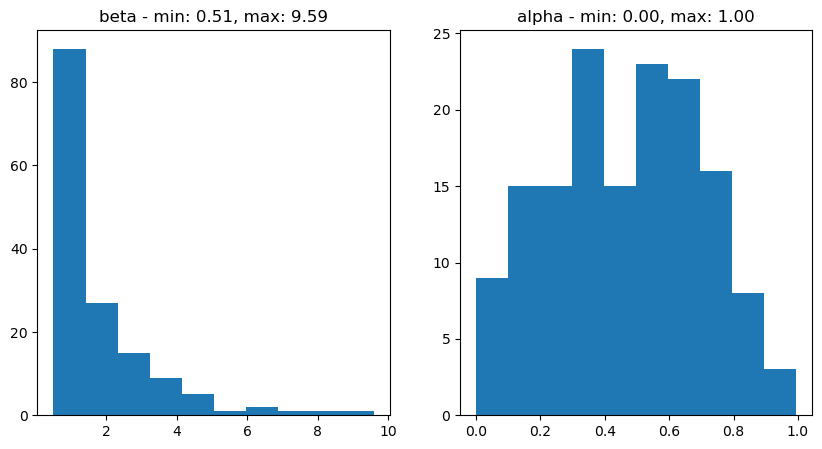

In [6]:
# plot 2 x 1 
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.hist(params[:,0]);
plt.title(f'beta - min: {min(params[:,0]):.2f}, max: {max(params[:,0]):.2f}');

plt.subplot(122)
plt.hist(params[:,1]);
plt.title(f'alpha - min: {min(params[:,1]):.2f}, max: {max(params[:,1]):.2f}');

In [7]:
def sim_RW(params, nblocks=3, ntrials=24, outcomes=None, norm2par=False):
    """
    Simulate the basic RW model.

    Args:
        `params` is a np.array of shape (nsubjects, nparams)
        `nblocks` is the number of blocks to simulate
        `ntrials` is the number of trials per block
    
    Returns:
        `simulated_dict` is a dictionary with the simulated data with the following keys:
            - `ev` is a np.array of shape (nsubjects, nblocks, ntrials+1, 2)
            - `ch_prob` is a np.array of shape (nsubjects, nblocks, ntrials, 2)
            - `choices` is a np.array of shape (nsubjects, nblocks, ntrials)
            - `choices_A` is a np.array of shape (nsubjects, nblocks, ntrials)
            - `rewards` is a np.array of shape (nsubjects, nblocks, ntrials)
            - `pe` is a np.array of shape (nsubjects, nblocks, ntrials)
            - `choice_nll` is a np.array of shape (nsubjects, nblocks, ntrials)
            - `params` is a np.array of the parameters used to simulate the data
                - `beta` is the softmax inverse temperature
                - `lr` is the learning rate

    """

    reverse     = 0
    nsubjects   = params.shape[0]
    ev          = np.zeros((nsubjects, nblocks, ntrials+1, 2))
    ch_prob     = np.zeros((nsubjects, nblocks, ntrials,   2))
    choices     = np.empty((nsubjects, nblocks, ntrials,), dtype='object')
    choices_A   = np.zeros((nsubjects, nblocks, ntrials,))
    rewards     = np.zeros((nsubjects, nblocks, ntrials,))
    pe          = np.zeros((nsubjects, nblocks, ntrials,))
    choice_nll  = np.zeros((nsubjects, nblocks, ntrials,))

    subj_dict = {}
    this_block_probs = [.8,.2]
    for subj_idx in tqdm(range(nsubjects)):
        beta, lr = params[subj_idx,:] 
        if norm2par:
            beta = norm2beta(beta, maxval=10)
            lr   = norm2alpha(lr) 
            
        for b in range(nblocks): # if nblocks == 1, then use reversals
            for t in range(ntrials):
                if nblocks == 1:
                    if (t+1) in [12, 24, 36 ,48, 60, 72, 84, 96, 108, 120]: # reverse
                        this_block_probs = this_block_probs[::-1]
                        if reverse == 1:
                            reverse = 0
                        elif reverse == 0:
                            reverse = 1

                if t == 0:
                    ev[subj_idx, b, t,:]    = [.5,.5]

                # calculate choice probability
                ch_prob[subj_idx, b, t,:] = softmax(ev[subj_idx, b, t, :], beta)

                # make choice
                choices[subj_idx, b, t]   = np.random.choice(['A', 'B'], 
                                                size=1, 
                                                p=ch_prob[subj_idx, b, t,:])[0]

                # get choice index
                if choices[subj_idx, b, t] == 'A':
                    c = 0
                    choices_A[subj_idx, b, t] = 1
                    # get outcome
                    if outcomes is None:
                        rewards[subj_idx, b, t]   = np.random.choice([1, 0], 
                                                        size=1, 
                                                        p=this_block_probs)[0]
                    else:
                        rewards[subj_idx, b, t]   = outcomes[b, t, c]
                else:
                    c = 1
                    choices_A[subj_idx, b, t] = 0
                    # get outcome
                    if outcomes is None:
                        rewards[subj_idx, b, t]   = np.random.choice([1, 0], 
                                                        size=1, 
                                                        p=this_block_probs[::-1])[0]
                    else:
                        rewards[subj_idx, b, t]   = outcomes[b, t, c]

                # calculate PE
                pe[subj_idx, b, t] = rewards[subj_idx, b, t] - ev[subj_idx, b, t, c]

                # update EV
                ev[subj_idx, b, t+1, :] = ev[subj_idx, b, t, :].copy()
                ev[subj_idx, b, t+1, c] = ev[subj_idx, b, t, c] + (lr * pe[subj_idx, b, t])
                
                choice_nll[subj_idx, b, t] = ch_prob[subj_idx, b, t, c].copy()

    # store params
    subj_dict = {'params'    : params,
                 'ev'        : ev, 
                 'ch_prob'   : ch_prob, 
                 'choices'   : choices, 
                 'choices_A' : choices_A, 
                 'rewards'   : rewards, 
                 'pe'        : pe, 
                 'choice_nll': choice_nll}

    return subj_dict

In [8]:
for ntrials, nblocks in [(24, 6)]:
    print(f'ntrials: {ntrials}, nblocks: {nblocks}')

    subj_dict = sim_RW(params, nblocks=nblocks, ntrials=ntrials, norm2par=False)

ntrials: 24, nblocks: 6


100%|██████████| 150/150 [00:01<00:00, 80.07it/s]


In [9]:
print(subj_dict.keys())

dict_keys(['params', 'ev', 'ch_prob', 'choices', 'choices_A', 'rewards', 'pe', 'choice_nll'])


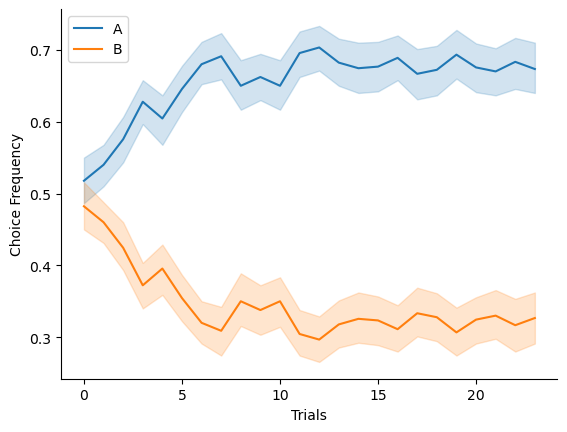

In [10]:
plotting.plot_choices(subj_dict['choices_A']) 

In [14]:
def fit_RW(params, choices, rewards, prior=None, output='npl'):
    ''' 
    Fit the basic RW model to a single subject's data.
        choices is a np.array with "A" or "B" for each trial
        rewards is a np.array with 1 (cue) or 0 (no cue) for each trial
        output is a string that specifies what to return (either 'nll' or 'all')
    '''
    beta, lr = params 
    beta = norm2beta(beta)
    lr   = norm2alpha(lr) 
    
    # make sure params are in range
    alpha_bounds = [0, 1]
    if lr < min(alpha_bounds) or lr > max(alpha_bounds):
        # print(f'lr = {i_alpha:.3f} not in range')
        return 10000000
    beta_bounds = [0.00001, 25]
    if beta < min(beta_bounds) or beta > max(beta_bounds):
        # print(f'beta = {beta:.3f} not in range')
        return 10000000

    nblocks, ntrials = rewards.shape

    ev          = np.zeros((nblocks, ntrials+1, 2))
    ch_prob     = np.zeros((nblocks, ntrials,   2))
    choices_A   = np.zeros((nblocks, ntrials,))
    pe          = np.zeros((nblocks, ntrials,))
    choice_nll  = 0

    for b in range(nblocks): #if nblocks==1, use reversals
        for t in range(ntrials):
            if t == 0:
                ev[b, t,:]    = [.5, .5]

            # get choice index
            if choices[b, t] == 'A':
                c = 0
                choices_A[b, t] = 1
            else:
                c = 1
                choices_A[b, t] = 0

            # calculate choice probability
            ch_prob[b, t,:] = softmax(ev[b, t, :], beta)
            
            # calculate PE
            pe[b, t] = rewards[b, t] - ev[b, t, c]

            # update EV
            ev[b, t+1, :] = ev[b, t, :].copy()
            ev[b, t+1, c] = ev[b, t, c] + (lr * pe[b, t])
            
            # add to sum of choice nll for the block
            choice_nll += -np.log(ch_prob[b, t, c])
        
    # get the total negative log likelihood
    negll = choice_nll
    
    if output == 'npl':
        if prior is not None:  # EM-fit: P(Choices | h) * P(h | O) should be maximised, therefore same as minimizing it with negative sign
            fval = -(-negll + prior['logpdf'](params))

            if any(prior['sigma'] == 0):
                this_mu = prior['mu']
                this_sigma = prior['sigma']
                this_logprior = prior['logpdf'](params)
                print(f'mu: {this_mu}')
                print(f'sigma: {this_sigma}')
                print(f'logpdf: {this_logprior}')
                print(f'fval: {fval}')
            
            if np.isinf(fval):
                fval = 10000000
            return fval
        else: # NLL fit 
            return negll
        
    elif output == 'all':
        subj_dict = {'params'     : [beta, lr],
                     'ev'         : ev, 
                     'ch_prob'    : ch_prob, 
                     'choices'    : choices, 
                     'choices_A'  : choices_A, 
                     'rewards'    : rewards, 
                     'pe'         : pe, 
                     'negll'      : negll,
                     'BIC'        : 8 * np.log(ntrials*nblocks) + 2*negll}
        return subj_dict

In [34]:
param_bounds = ((0.0001, betamax), # beta
                (0, 1))       # lr

# create a list of lists with choices and rewards for each subject
all_data = []
for idx, (choices, rewards) in enumerate(zip(subj_dict['choices'], subj_dict['rewards'])):
    all_data += [[choices, rewards]]

In [35]:
m, h, posterior, NPL, NLPrior, NLL = EMfit(all_data, fit_RW, param_bounds)

14819.511 (000), 13237.121 (001), 13182.744 (002), 13173.014 (003), 13166.493 (004), 

In [ ]:
 # get covariance matrix
_, _, _, covmat_out = compGauss_ms(m,h,2)

# Fill in general information
modout = {}
modelID = 'RW'
modout[modelID] = {}
modout[modelID]['date'] = datetime.date.today().strftime('%Y%m%d')
modout[modelID]['behaviour'] = subj_dict  # copy behaviour here, just in case

# Fill in fit information
real_params = m.T.copy()
for subj_idx in range(nsubjects):
    real_params[subj_idx, 0] =   norm2beta(m[0, subj_idx]) # beta
    real_params[subj_idx, 1] =  norm2alpha(m[1, subj_idx]) # lr

modout[modelID]['fit'] = {}
modout[modelID]['fit']['norm_params'] = m
modout[modelID]['fit']['params'] = real_params
modout[modelID]['fit']['param_names'] = ['beta', 'lr']
modout[modelID]['fit']['inverse_hess'] = h
modout[modelID]['fit']['gauss.mu'] = posterior['mu']
modout[modelID]['fit']['gauss.sigma'] = posterior['sigma']
modout[modelID]['fit']['gauss.cov'] = covmat_out
try:
    modout[modelID]['fit']['gauss.corr'] = np.corrcoef(covmat_out)
except:
    print('covariance mat not square, symmetric, or positive semi-definite')
    modout[modelID]['fit']['gauss.corr'] = np.eye(nparams)
modout[modelID]['fit']['npl'] = NPL  # note: this is the negative joint posterior likelihood
modout[modelID]['fit']['NLPrior'] = NLPrior
modout[modelID]['fit']['nll'] = NPL - NLPrior
modout[modelID]['fit']['aic'] = 2*nparams + 2*modout[modelID]['fit']['nll']
modout[modelID]['fit']['bic'] = np.log(ntrials*nblocks)*nparams + 2*modout[modelID]['fit']['nll']
modout[modelID]['fit']['lme'] = []
modout[modelID]['fit']['convCrit'] = convCrit

# Make sure you know if BIC is positive or negative! and replace lme with
# bic if covariance is negative.
# Error check that BICs are in a similar range
# Get subject specifics
goodHessian = np.zeros(nsubjects)
modout[modelID]['fit']['ev']          = np.zeros((nsubjects, nblocks, ntrials+1, 2))
modout[modelID]['fit']['ch_prob']     = np.zeros((nsubjects, nblocks, ntrials,   2))
modout[modelID]['fit']['choices']     = np.empty((nsubjects, nblocks, ntrials,), dtype='object')
modout[modelID]['fit']['choices_A']   = np.zeros((nsubjects, nblocks, ntrials,))
modout[modelID]['fit']['rewards']     = np.zeros((nsubjects, nblocks, ntrials,))
modout[modelID]['fit']['pe']          = np.zeros((nsubjects, nblocks, ntrials,))
modout[modelID]['fit']['negll']       = np.zeros((nsubjects,))

# Inserted this Jan 2020: Pat & Miriam from mfit_optimize_hierarchical.m from Sam Gershman
for subj_idx in range(nsubjects):
    try:
        det_inv_hessian = np.linalg.det(h[:, :, subj_idx])
        hHere = np.linalg.slogdet(h[:, :, subj_idx])[1]
        L = -NPL - 0.5 * np.log(1 / det_inv_hessian) + (nparams / 2) * np.log(2 * np.pi)
        goodHessian[subj_idx] = 1
    except:
        print('Hessian is not positive definite')
        try:
            hHere = np.linalg.slogdet(h[:,:,subj_idx])[1]
            L = np.nan
            goodHessian[subj_idx] = 0
        except:
            print('could not calculate')
            goodHessian[subj_idx] = -1
            L = np.nan
    modout[modelID]['fit']['lme'] = L
    modout[modelID]['fit']['goodHessian'] = goodHessian

    # Get subjectwise model predictions# get info for current subject
    choices = subj_dict['choices'][subj_idx,:,:]
    rewards = subj_dict['rewards'][subj_idx,:,:]
    
    model_fits = fit_RW(m[:,subj_idx], choices, rewards, prior=None, output='all')

    # store model fits
    modout[modelID]['fit']['ev'][subj_idx,:,:,:] = model_fits['ev']
    modout[modelID]['fit']['ch_prob'][subj_idx,:,:,:] = model_fits['ch_prob']
    modout[modelID]['fit']['choices'][subj_idx,:,:] = model_fits['choices']
    modout[modelID]['fit']['choices_A'][subj_idx,:,:] = model_fits['choices_A']
    modout[modelID]['fit']['rewards'][subj_idx,:,:] = model_fits['rewards']
    modout[modelID]['fit']['pe'][subj_idx,:,:] = model_fits['pe']
    modout[modelID]['fit']['negll'][subj_idx] = model_fits['negll']

# Save output
# with open(f'{save_dir}/emfit_ntrials-{ntrials}_nblocks-{nblocks}_nsubjects-{nsubjects}.pkl', 'wb') as f:
#     pickle.dump(modout, f)

In [ ]:
for param_idx, param_label in enumerate(['beta', 'lr']):
    simulated_param = subj_dict['params'][:,param_idx]
    fitted_params = real_params[:,param_idx]
    plotting.plot_scatter(simulated_param, f'Simulated {param_label}', 
                 fitted_params, f'Estimated {param_label}')

ValueError: arrays must all be same length

In [120]:
# import scipy.io

# # Save m and h to a .mat file
# data = {'m': m, 'h': h}
# scipy.io.savemat('Mean_Hess_example.mat', data)

# curmu,cursigma,flagcov,covmat_out = compGauss_ms(m,h,2)
# print(curmu,cursigma,flagcov,covmat_out )